# Assignment 3

## Group 32

*  Prerak Gupta - 03717790
*  Chen Zhiyue - 03721645
*  Jonathan Narvaez - 03708467
*  Hao Ma - 03721529
*  Zhen Zhou - 03721400

In [1]:
import numpy as np
import imageio
from os import listdir
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
%matplotlib inline

## The Kernel Trick

### Task 1

On Moodle you will find a Jupyter-Notebook that contains a function for dimensionality reduction via PCA. The function `linear_pca` expects a data matrix $\mathbf{X}\in\mathit{R}^{p\times N}$ and a number of PCs $k$ and returns the first $k$ PCA scores for the matrix $\mathbf{X}$.

In [2]:
def linear_pca(X, k):
    mu=np.mean(X,axis=1)
    X_c=X-np.expand_dims(mu,axis=1)
    [U,Sigma,VT]=np.linalg.svd(X_c,full_matrices=False)
    S=np.expand_dims(Sigma[:k],axis=1)*VT[:k,:]
    return S

* Provide code that tests the function with selected images from the provided MNIST training dataset by visualizing the first 2 scores in a scatter plot.

(784, 1000)


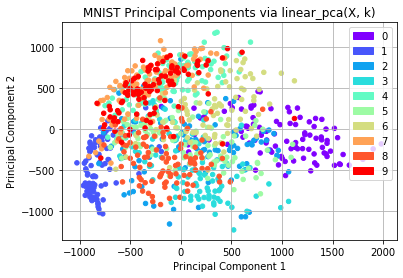

In [8]:
# Set number of classes
data_folder = 'mnist'
num_classes = len(listdir(data_folder))
digit_prefix=['d%d' % i for i in range(0, num_classes)]

print(enumerate(digit_prefix))
# Sample colors from spectrum to represent each class
colors = cm.rainbow(np.linspace(0, 1, num_classes))

# Find number of samples in each class
n = np.zeros(num_classes)
for i, dp in enumerate(digit_prefix):
    class_samples = listdir(data_folder + '/' + dp)
    n[i]=100
    #n[i] = len(class_samples)        # number of samples to read from each class


N = int(sum(n))        # Total #samples
X = np.zeros((784,N))  # Data matrix
Y = np.zeros(N)        # Label vector
C = np.zeros((N, 4))   # Color vector

# Read data and populate X, Y and C
for i, dp in enumerate(digit_prefix):
    Y[int(sum(n[:i])):int(sum(n[:i+1]))] = i
    C[int(sum(n[:i])):int(sum(n[:i+1])), :] = np.expand_dims(colors[i],axis=0)
    for j in range(int(n[i])):
        X[:, int(sum(n[:i]))+j] = np.float64(imageio.imread('mnist/'+dp+'/'+dp+'_'+'%04d.png'%(j+1)).ravel())

# Get first k principal components of data
print(X.shape)
k = 2
S = linear_pca(X, k)

# Randomize order of data for plotting
# (so one class is not entirely covered by another)
idx_new = np.arange(N)
#np.random.shuffle(idx_new)

# First 2 principal components
PC1 = S[0, idx_new]
PC2 = S[1, idx_new]

# Plot the first 2 principal components of data
plt.scatter(PC1, PC2, c=C[idx_new, :], s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MNIST Principal Components via linear_pca(X, k)')
legend_patch = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(0, num_classes)]
plt.legend(handles=legend_patch)
plt.grid()
plt.show()

* Complete the function `gram_pca` such that it has the same functionality as `linear_pca` but expects a gram matrix $\mathbf{K}=\mathbf{X}^T\mathbf{X}$ instead of the data matrix $\mathbf{X}$ as its input. Do not assume that $\mathbf{K}$ was produced from centered data. Note: It is important to be consistent in notation here. E.g., for a data matrix of 1000 MNIST images, we have $\mathbf{X}\in\mathit{R}^{784\times1000}$ and $\mathbf{K}\in\mathit{R}^{1000\times1000}$.

In [13]:
def gram_pca(K, k):
    n = K.shape[0]
    H = np.identity(n) - np.ones(n) / n
    K_centered = H.dot(K).dot(H)
    
    [V,Sigma,VT]=np.linalg.svd(K_centered, full_matrices=False)
    
    Sigma = np.sqrt(Sigma[:k])
    Sigma = np.dot(np.diag(Sigma), VT[:k])  

    return Sigma

* Test your implementation and show that `gram_pca(np.dot(X.T,X), k)` yields results equivalent to those of `linear_pca(X, k)`.

(1000, 1000)


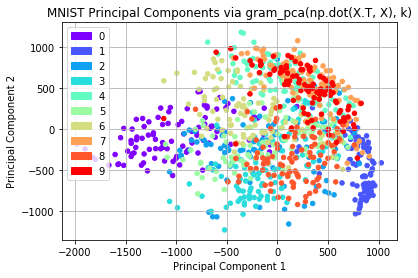

In [14]:
# Get first k principal components of data via gram_pca
k = 2 
K = np.dot(X.T, X)
S_gram = gram_pca(K, k)
print(K.shape)
# First 2 principal components via gram_pca
PC1_gram = S_gram[0, idx_new]
PC2_gram = S_gram[1, idx_new]

# Plot the first 2 gram principal components of data
plt.scatter(PC1_gram, PC2_gram, c=C[idx_new, :], s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MNIST Principal Components via gram_pca(np.dot(X.T, X), k)')
legend_patch = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(0, num_classes)]
plt.legend(handles=legend_patch)
plt.grid()
plt.show()

* There is an unknown vector space $\mathbb{H}$, equipped with an inner product $\langle.,.\rangle_{\mathbb{H}}$ and a function

$$
\varphi:\mathbb{R}^p\rightarrow\mathbb{H},
$$

such that

$$
\langle\varphi(\mathit{x}),\varphi(\mathit{y})\rangle_\mathbb{H} = \exp{(-\frac{{\|\mathit{x}-\mathit{y}\|}^2}{2\sigma^2})}
$$

holds for every $\mathit{x},\mathit{y}\in\mathbb{R}^p$. The expression on the right-hand side of the equation is called the *Gaussian kernel* and $\sigma$ is a parameter to choose by hand.

The function `gaussian_kernel_pca` expects a data matrix $\mathit{X}$, a reduced dimension number $k$ and a parameter $\sigma$. It returns the first $k$ *Kernel PCA* scores of the data. In other words, the function returns the first $k$ PCA scores of

$$
\varphi(\mathit{x}_1),\varphi(\mathit{x}_2),...,\varphi(\mathit{x}_N),
$$

where $\mathit{x}_i$ denotes the $i$-th data sample/$i$-th column of the data matrix. The function `gaussian_kernel_pca` is already written, but for it to work, the function `compute_gaussian_gram_matrix` must return correct results. Complete `compute_gaussian_gram_matrix` accordingly.

In [6]:
def compute_gaussian_gram_matrix(X, sigma):
    K = np.zeros((X.shape[1], X.shape[1]))
    
    for i in range(X.shape[1]):
        # only compute K above main diagonal (inclusive)
        for j in range(i):
            # get all pair-wise differences in data
            pair_diff = X[:, i] - X[:, j]
            # take the squared norm for each of them
            sq_norm = np.sum(pair_diff*pair_diff)
            # plug each squared norm into the gaussian kernel
            K[i, j] = np.exp(-sq_norm/(2*(sigma**2)))
            # K is symmetric
            K[j, i] = K[i, j]
    
    return K

def gaussian_kernel_pca(X, k, sigma):
    K=compute_gaussian_gram_matrix(X,sigma)
    S=gram_pca(K,k)
    return S

* Test `gaussian_kernel_pca` with some MNIST train images and $\sigma = 1000$.

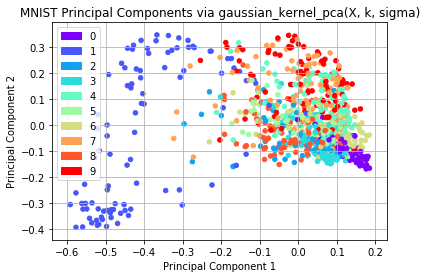

In [7]:
# Get first k principal components of data via gaussian_kernel_pca
k = 2
sigma = 1000
S_gauss = gaussian_kernel_pca(X, k, sigma)

# First 2 principal components via gaussian_kernel_pca
PC1_gauss = S_gauss[0, idx_new]
PC2_gauss = S_gauss[1, idx_new]

# Plot the first 2 gaussian-kernel principal components of data
plt.scatter(PC1_gauss, PC2_gauss, c=C[idx_new, :], s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MNIST Principal Components via gaussian_kernel_pca(X, k, sigma)')
legend_patch = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(0, num_classes)]
plt.legend(handles=legend_patch)
plt.grid()
plt.show() 